In [313]:
%matplotlib inline
from kpmrcnn.mrcnn_segmentation import COCODPredictor
from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.modeling.roi_heads.mask_head.inference import Masker
import kpnet.network.inferenceNet as kpNetInference
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [314]:
mrcnn_cfg_path = "/home/stanlew/src/kpam/mankey_recreate/kpmrcnn/e2e_mask_rcnn_R_50_FPN_1x_caffe2_singleobj.yaml"

In [315]:
cfg.merge_from_file(mrcnn_cfg_path)

In [316]:
mrcnn_predictor = COCODPredictor(cfg, min_image_size=800, confidence_threshold=0.7)

In [317]:
rgb_image_file = "/home/stanlew/src/kpam/data/test_images/extreme_mugs/mug_03/4_rgb.png"
depth_image_file = "/home/stanlew/src/kpam/data/test_images/extreme_mugs/mug_03/4_depth.png"

In [318]:
rgb_image_cv = cv2.imread(rgb_image_file)
depth_image_cv = cv2.imread(depth_image_file, cv2.IMREAD_ANYDEPTH)
depth_image_cv.shape

(480, 640)

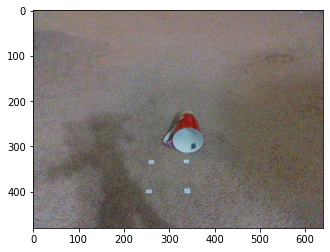

In [319]:
plt.imshow(cv2.cvtColor(rgb_image_cv, cv2.COLOR_BGR2RGB))

In [320]:
predictions = mrcnn_predictor.run_on_opencv_image(rgb_image_cv)

In [321]:
masks = predictions.get_field('mask').numpy()
labels = predictions.get_field('labels').numpy()
boxes = predictions.bbox.numpy()
num_obj = masks.shape[0]
rgb_image_cv_boxed = rgb_image_cv.copy()

In [322]:
for i in range(num_obj):
    label_i = int(labels[i])
    if label_i < len(mrcnn_predictor.CATEGORIES):
        name_i = mrcnn_predictor.CATEGORIES[label_i]
        print(name_i)
    else:
        print('category-%d' % i)

    x_offset = int(boxes[i, 0])
    y_offset = int(boxes[i, 1])
    width = int(boxes[i, 2] - boxes[i, 0])
    height = int(boxes[i, 3] - boxes[i, 1])
    
    rgb_image_cv_boxed = cv2.rectangle(rgb_image_cv_boxed, (x_offset, y_offset), (x_offset + width, y_offset + height), (255,0,0), 5)

    mask_i = masks[i, 0,:,:].astype(np.uint16)

person


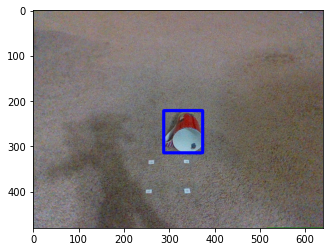

In [323]:
plt.imshow(cv2.cvtColor(rgb_image_cv_boxed, cv2.COLOR_BGR2RGB))

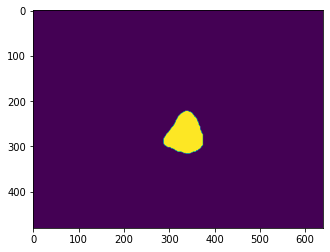

In [324]:
plt.imshow(masks[0, 0,:,:].astype(np.uint16))

In [325]:
depth_image_cv.shape

(480, 640)

In [326]:
# Camera Constants from the RealSense
ppx = 322.774
ppy = 236.928
fx = 615.113
fy = 615.117

rs_matrix = np.array([[fx,0,ppx],[0,fy,ppy],[0,0,1]])

In [327]:
rs_matrix

array([[615.113,   0.   , 322.774],
       [  0.   , 615.117, 236.928],
       [  0.   ,   0.   ,   1.   ]])

In [328]:
kpNetResult = kpNetInference.doInference(rgb_image_cv, depth_image_cv, \
                                         (int(boxes[0, 0]), int(boxes[0, 1])), \
                                         (int(boxes[0, 2] - boxes[0, 0]), int(boxes[0, 3] - boxes[0, 1])), \
                                        "/home/stanlew/src/kpam/mankey_recreate/training_checkpoints_all_data/checkpoint-135.pth")

In [329]:
rgb_image_cv_kp_labeled = rgb_image_cv.copy()
label_radius = 5
label_colors = [(255,0,0),(0,255,0),(0,0,255)]
for i in range(kpNetResult.shape[1]):
    x = kpNetResult[0, i]
    y = kpNetResult[1, i]
    z = kpNetResult[2, i]
    u,v,w = np.matmul(rs_matrix, [x,y,z])
    label_center = (int(u/w), int(v/w))
    rgb_image_cv_kp_labeled = cv2.circle(rgb_image_cv_kp_labeled, label_center, label_radius, label_colors[i], -1)
    print("x = {0}, y = {1}, z = {2}".format(x,y,z))
    print("u = {0}, v = {1}, w = {2}".format(u,v,w))

x = 0.031674956375414544, y = 0.057465834161394655, z = 0.8652735595703125
u = 298.7714853576984, v = 240.3557454337296, w = 0.8652735595703125
x = -0.01913048704739302, y = 0.07135151480601809, z = 0.858207275390625
u = 265.23958382775055, v = 247.22286307668344, w = 0.858207275390625
x = 0.02455336496542484, y = 0.06766775384816676, z = 0.8684578857421875
u = 295.4187195965262, v = 247.3855756969478, w = 0.8684578857421875


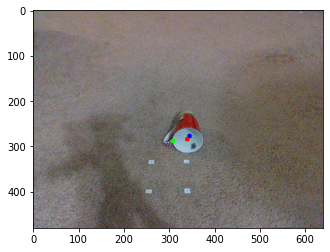

In [330]:
plt.imshow(cv2.cvtColor(rgb_image_cv_kp_labeled, cv2.COLOR_BGR2RGB))